In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch  import nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

%matplotlib inline

In [2]:
fashion_train = pd.read_csv('/content/fashion-mnist_train.csv')
fashion_test  = pd.read_csv('/content/fashion-mnist_test.csv')
print(fashion_train.head())
print(fashion_test.head())

   label  pixel1  pixel2  pixel3  ...  pixel781  pixel782  pixel783  pixel784
0      2       0       0       0  ...         0         0         0         0
1      9       0       0       0  ...         0         0         0         0
2      6       0       0       0  ...         0         0         0         0
3      0       0       0       0  ...         0         0         0         0
4      3       0       0       0  ...         0         0         0         0

[5 rows x 785 columns]
   label  pixel1  pixel2  pixel3  ...  pixel781  pixel782  pixel783  pixel784
0      0       0       0       0  ...         0         0         0         0
1      1       0       0       0  ...         0         0         0         0
2      2       0       0       0  ...        31         0         0         0
3      2       0       0       0  ...       222        56         0         0
4      3       0       0       0  ...         0         0         0         0

[5 rows x 785 columns]


In [3]:
print(fashion_train.shape)  #  This is a huge data  set
print(fashion_test.shape)
print(fashion_train['label'].value_counts())

(60000, 785)
(10000, 785)
9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64


In [4]:
#Let's have split the data into features and target
X_train = fashion_train.drop('label', axis=1)
X_train = X_train.to_numpy()
print(X_train.shape)

X_test= fashion_test.drop('label', axis=1)
X_test = X_test.to_numpy()
print(X_test.shape)


(60000, 784)
(10000, 784)


In [5]:
y_train = fashion_train['label']
y_train = y_train.to_numpy()
print(y_train.shape)

y_test = fashion_test['label']
y_test = y_test.to_numpy()
print(y_test.shape)


(60000,)
(10000,)


In [6]:
#Let's see how an image looks like. This is image is blur because  it is just 28 x 28 pixel. Which is too leass as a size
img = X_train[1].reshape(28,28).astype(int)

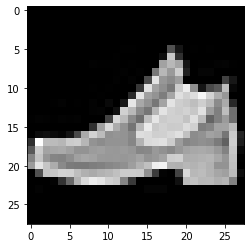

In [7]:
plt.imshow(img, cmap='gray')
plt.show()

In [8]:
#scalar = StandardScaler()
#X_train = scalar.fit_transform(X_train)
#X_test= scalar.fit_transform(X_test)

In [9]:
class TabDataset(Dataset):
  def __init__(self,x,y):
    self.x = x
    self.y = y
    self.x = torch.from_numpy(self.x).type(torch.float32)
    self.y = torch.from_numpy(self.y)

  def __len__(self): return len(self.x)

  def __getitem__(self, idx): return self.x[idx], self.y[idx]

In [10]:
def get_dataloader(X_train, X_test, y_train, y_test, bs):
  #Feature Scaling
  X_train = X_train/255.0
  X_test = X_test/255.0
  
  #Dataset
  train_ds = TabDataset(X_train, y_train)
  test_ds = TabDataset(X_test, y_test)

  #DataLoader
  train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
  test_dl = DataLoader(test_ds,  batch_size=bs, shuffle=True)

  return train_dl, test_dl

In [11]:
def first(x):
  try: return next(iter(x))
  except StopIteration: return None

In [12]:
bs = 512  #batch size
train_dl, test_dl = get_dataloader(X_train, X_test, y_train, y_test, bs)

xb, yb = first(train_dl)
xb.shape, yb.shape

(torch.Size([512, 784]), torch.Size([512]))

In [13]:
def get_model(n_in, n_out):
  return nn.Sequential(
      nn.Linear(n_in, 512),
      nn.ReLU(),
      nn.Linear(512, 128),
      nn.ReLU(),
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, n_out)
      )

In [14]:
model = get_model(784, 10)
model

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=32, bias=True)
  (7): ReLU()
  (8): Linear(in_features=32, out_features=10, bias=True)
)

In [15]:
def batch_accuracy(xb, yb):
  predictions = torch.sigmoid(xb)
  correct = (predictions.argmax(1)) == yb
  return correct.float().mean()

In [16]:
def validate_epoch(model, metric):
  accuracy = [metric(model(xb.float()), yb) for xb, yb in test_dl]
  return round(torch.stack(accuracy).mean().item(), 4)

In [17]:
def loss_func(input, target):
  loss = nn.CrossEntropyLoss()
  return loss(input, target.long())

In [18]:
def train_model(model, metric, epochs):
  for i in range(epochs):
    for xb, yb  in train_dl:
      preds = model(xb.float())
      loss = loss_func(preds, yb)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    print(validate_epoch(model, metric), end=' ')


In [19]:
optimizer  = optim.Adam(model.parameters(), lr = 0.01)
train_model(model, metric = batch_accuracy, epochs=5)

0.8215 0.8538 0.8729 0.8783 0.8474 

In [20]:
test_data = X_train[1]
out_predict = model(torch.Tensor(test_data).float())
out_predict.argmax()

tensor(9)

In [ ]:
# And here we go. Class 9 is a Ankle Boot